<a href="https://colab.research.google.com/github/NguyenHien19/GAN/blob/main/GAN_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# Import libraries

import numpy as np
import torch
from torchvision import datasets
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.optim as optim
import pickle as pkl
import matplotlib.pyplot as plt
%matplotlib inline


In [25]:

# Loading MNIST dataset

batch_size = 64

# get datasets
dataset = MNIST(root='data/', download=True) # 60000 images
train_data = MNIST(root='data', train=True, transform=ToTensor()) # 60000 images
test_data = MNIST(root='data/', train=False, transform=ToTensor()) # 10000 images

#prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=0)



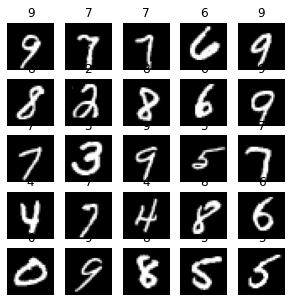

In [26]:

# Visualizing the data

labels_map = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9',
}

figure = plt.figure(figsize=(5, 5))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_index = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_index]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()


In [33]:

# Define discriminator

class Discriminator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
 
        # define layers: 3 hidden layers and 1 fully-connected layer: 512, 256, 128, 1
        self.l1=nn.Linear(input_size, 512) 
        self.l2=nn.Linear(512, 256)
        self.l3=nn.Linear(256, 128)
        self.l4=nn.Linear(128, 1) # output is 0 : fake image or 1 : real image

        self.dropout=nn.Dropout(0.3)
    
    def forward(self, x):
        # turn (1, 28, 28) image tensor to (784)
        x=x.view(-1,28*28)
        
        # pass x through all layers apply leaky relu activation to all hidden layers
        hidden_model = nn.LeakyReLU(0.2)

        x = hidden_model(self.l1(x))
        x=self.dropout(x)
        x = hidden_model(self.l2(x))
        x=self.dropout(x)
        x = hidden_model(self.l3(x))
        x=self.dropout(x)
 
        output=self.l4(x)
        return output


In [34]:

# Define generator

class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
 
        # define all layers: 3 hidden layers and 1 fully-connected layer: 128, 256, 512, 784
        self.l1=nn.Linear(input_size, 128)
        self.l2=nn.Linear(128, 256)
        self.l3=nn.Linear(256, 512)
        self.l4=nn.Linear(512, 784)

        self.dropout=nn.Dropout(0.3)

    def forward(self, x):
        # pass x through all layers and final layer should have tanh applied
        hidden_model = nn.LeakyReLU(0.2)

        x = hidden_model(self.l1(x))
        x=self.dropout(x)
        x = hidden_model(self.l2(x))
        x=self.dropout(x)
        x = hidden_model(self.l3(x))
        x=self.dropout(x)

        output=torch.tanh(self.l4(x)) 
        return output


In [35]:

# Hyperparameters

# Discriminator hyperparams
input_size = 784
d_output_size = 1

# Generator hyperparams
z_noise = 100
g_output_size = 784


In [36]:

# Build model

D = Discriminator(input_size)
G = Generator(z_noise)

print(D)
print()
print(G)


Discriminator(
  (l1): Linear(in_features=784, out_features=512, bias=True)
  (l2): Linear(in_features=512, out_features=256, bias=True)
  (l3): Linear(in_features=256, out_features=128, bias=True)
  (l4): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (l1): Linear(in_features=100, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=256, bias=True)
  (l3): Linear(in_features=256, out_features=512, bias=True)
  (l4): Linear(in_features=512, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [41]:

# Loss

def real_img_loss(D_out, smooth=False):
    batch_size=D_out.size(0)
    if smooth:
        labels=torch.ones(batch_size)*0.9
    else:
        labels=torch.ones(batch_size)
        
    criterion=nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(),labels)
    return loss

def fake_img_loss(D_out):
    batch_size=D_out.size(0)
    labels=torch.zeros(batch_size) 
        
    criterion=nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(),labels)
    return loss

In [42]:

# Optimizer

# learning rate for optimizers
lr = 0.0002

# Create optimizers for the discriminator and generator
d_opt = optim.Adam(D.parameters(),lr)
g_opt = optim.Adam(G.parameters(),lr)


In [45]:

# Training

num_epochs = 20
samples = []
losses = []
sample_size=16

fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_noise))
fixed_z = torch.from_numpy(fixed_z).float()

D.train()
G.train()

for epoch in range(num_epochs):
   for i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)

        real_images = real_images*2 -1 # rescale input images from [0,1) to [-1, 1)

        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        d_opt.zero_grad()

        # 1. Train with real images
        D_real = D(real_images)
        d_real_loss = real_img_loss(D_real, smooth=True)
 
        # 2. Train with fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_noise))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
 
        # Compute the discriminator losses on fake images     
        D_fake = D(fake_images)
        d_fake_loss = fake_img_loss(D_fake)
 
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_opt.step()


        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_opt.zero_grad()
 
        # 1. Train with fake images and flipped labels

        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_noise))
        z = torch.from_numpy(z).float()

        # Compute the discriminator losses on fake images using flipped labels!
        fake_images = G(z)
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake)

        # perform backprop 
        g_loss.backward()
        g_opt.step()

        # Print some loss stats
        if i % 400 == 0:
             print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss:  {:6.4f}'.format(epoch+1, num_epochs, d_loss.item(), g_loss.item()))

   ## AFTER EACH EPOCH##
   losses.append((d_loss.item(), g_loss.item()))
   G.eval() 
   samples_z = G(fixed_z)
   samples.append(samples_z)
   G.train()

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
   pkl.dump(samples, f)


Epoch [    1/   20] | d_loss: 0.8706 | g_loss:  4.8527
Epoch [    1/   20] | d_loss: 0.6925 | g_loss:  4.0929
Epoch [    1/   20] | d_loss: 0.8680 | g_loss:  3.0133
Epoch [    2/   20] | d_loss: 0.7538 | g_loss:  2.8581
Epoch [    2/   20] | d_loss: 0.6255 | g_loss:  3.8210
Epoch [    2/   20] | d_loss: 0.6396 | g_loss:  3.2134
Epoch [    3/   20] | d_loss: 0.7681 | g_loss:  2.8329
Epoch [    3/   20] | d_loss: 0.7550 | g_loss:  2.7981
Epoch [    3/   20] | d_loss: 0.8707 | g_loss:  1.5918
Epoch [    4/   20] | d_loss: 1.1486 | g_loss:  2.1218
Epoch [    4/   20] | d_loss: 0.8144 | g_loss:  2.4420
Epoch [    4/   20] | d_loss: 0.8937 | g_loss:  2.1270
Epoch [    5/   20] | d_loss: 0.9533 | g_loss:  1.9982
Epoch [    5/   20] | d_loss: 1.1101 | g_loss:  2.1095
Epoch [    5/   20] | d_loss: 0.9528 | g_loss:  3.2267
Epoch [    6/   20] | d_loss: 0.9959 | g_loss:  2.4416
Epoch [    6/   20] | d_loss: 0.9120 | g_loss:  2.7083
Epoch [    6/   20] | d_loss: 0.9756 | g_loss:  2.7764
Epoch [   

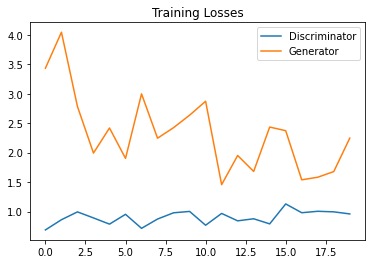

In [47]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()